In [1]:
import numpy as np
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import estimator as est
rng = np.random.default_rng(seed=315)

from forestflow.model_p3d_arinyo import ArinyoModel
from forestflow.archive import GadgetArchive3D
from lace.cosmo import camb_cosmo
from forestflow import pcross
from scipy.interpolate import interp1d

Load the data

In [2]:
# set sim_name
sim_name='sim_pair_30' # other version will be 'diffSeed'
sim_dir='central'
snap_num = 6
# set phase
phase = "sim_minus"
# set axis number
axis = 1


In [3]:
# load the skewers
meas_path = "/Users/mlokken/research/lyman_alpha/data/"
delta_x = np.load(meas_path+"snap_{:d}/delta_x/skewers_6_psim_minus_ax1_Ns768_wM0.05_sT1.0_sg1.0.npz".format(snap_num))
delta_flux_x = delta_x['delta_flux_x'] # these are already normalized
Np = delta_flux_x.shape[1]
L = delta_x['L_Mpc']
pix_spacing = L/Np
print("pixel spacing is", pix_spacing, "Mpc")
# xpar = delta_x['xpar'] # this is still wrong for some reason, redefined below
delta_x.close()
xpar = np.arange(0, L, pix_spacing)+pix_spacing/2.

pixel spacing is 0.05 Mpc


In [4]:
Np = delta_flux_x.shape[1]
nskew = delta_flux_x.shape[0]
nside = np.sqrt(nskew).astype(int)
print(f"Box is {L} Mpc per side with {nside} skewers per side")
print(f"Spacing between pixels along line-of-sight = {pix_spacing} Mpc")

# bin delta_flux along line-of-sight
binsize = 10
if Np%binsize != 0:
    print("Np is not divisible by binsize")
    sys.exit()
delta_flux_b, xpar_b = est.bin_spectra(delta_flux_x, xpar, binsize)
Np_b=delta_flux_b.shape[1]
pix_spacing_b = xpar_b[1]-xpar_b[0]
print(f"Spacing between pixels along line-of-sight after binning = {pix_spacing_b} Mpc")

# get the positions
xpos = np.linspace(0,L,nside)
ypos = np.linspace(0,L,nside)
print("spacing between neighboring skewers is {:.2f} Mpc".format(xpos[1]-xpos[0]))
positions = np.array([[x,y] for x in xpos for y in ypos])
subsel=True
nsub=100
if subsel:
    randoms = rng.choice(len(positions), size=nsub)
    sel = np.zeros(len(positions), dtype=bool)
    sel[randoms] = True
else:
    sel = np.ones(len(positions), dtype=bool)
positions_sel = np.copy(positions)
positions_sel[~sel] = np.nan
delta_flux_x[~sel] = np.nan
delta_flux_b[~sel] = np.nan

# reshape into a grid
delta_flux_x = np.reshape(delta_flux_x, (int(nside), int(nside), Np))
delta_flux_b = np.reshape(delta_flux_b, (int(nside), int(nside), Np_b))
position_grid = np.reshape(positions_sel, (int(nside), int(nside), 2))

Box is 67.5 Mpc per side with 768 skewers per side
Spacing between pixels along line-of-sight = 0.05 Mpc
Number of bins: 135
Spacing between pixels along line-of-sight after binning = 0.49999999999999994 Mpc
spacing between neighboring skewers is 0.09 Mpc


In [5]:
delta_x_matrix_binned = est.make_delta_x_matrix(L, Np_b, xpar_b)

Load the model

In [6]:
# get the model

path_program = "/Users/mlokken/research/lyman_alpha/software/ForestFlow/"

folder_lya_data = path_program + "data/best_arinyo/"

Archive3D = GadgetArchive3D(
    base_folder=path_program[:-1],
    folder_data=folder_lya_data,
    force_recompute_plin=False,
    average="both",
)


In [7]:
# read the model
central = Archive3D.get_testing_data("mpg_central")
zs = np.array([central[snap_num]['z']]) 

k3d_Mpc = central[snap_num]['k3d_Mpc']
mu3d = central[snap_num]['mu3d']
p3d_Mpc = central[snap_num]['p3d_Mpc']
Plin = central[snap_num]['Plin']

k1d_Mpc = central[snap_num]['k_Mpc']
p1d_Mpc = central[snap_num]['p1d_Mpc']

arinyo_params = central[snap_num]['Arinyo'] # best-fitting Arinyo params
cosmo_params  = central[snap_num]['cosmo_params']

print(zs)

[3.]


In [8]:
# input the details into the ArinyoModel class
cosmo = camb_cosmo.get_cosmology_from_dictionary(cosmo_params)
camb_results = camb_cosmo.get_camb_results(cosmo, zs=zs, camb_kmax_Mpc=1000)
arinyo = ArinyoModel(cosmo=cosmo, camb_results=camb_results, zs=zs, camb_kmax_Mpc=1000)
p1d = arinyo.P1D_Mpc(zs[0], np.linspace(0,10,20), parameters=arinyo_params) # get P1D at target z

In [9]:
# Get the weighting matrix
Leff=1000
Np_fine=40000
xfine=np.linspace(0.0,Leff,Np_fine)
spacing_fine=Leff/Np_fine
kfine = np.fft.rfftfreq(Np_fine, spacing_fine)*2*np.pi
p1d_fine = arinyo.P1D_Mpc(zs[0], kfine, parameters=arinyo_params)
xi_fid = np.fft.irfft(p1d_fine) / spacing_fine # to cancel the Mpc.
xi_fid_func = interp1d(xfine, xi_fid, kind='slinear', fill_value='extrapolate')
C0_mat_b = est.c0(xi_fid_func, delta_x_matrix_binned)
C0_invmat_b = np.linalg.inv(C0_mat_b)
# get the fiducial signal
S_fiducial_b = est.s_fid(arinyo, zs[0], arinyo_params, delta_x_matrix_binned, pix_spacing_b)

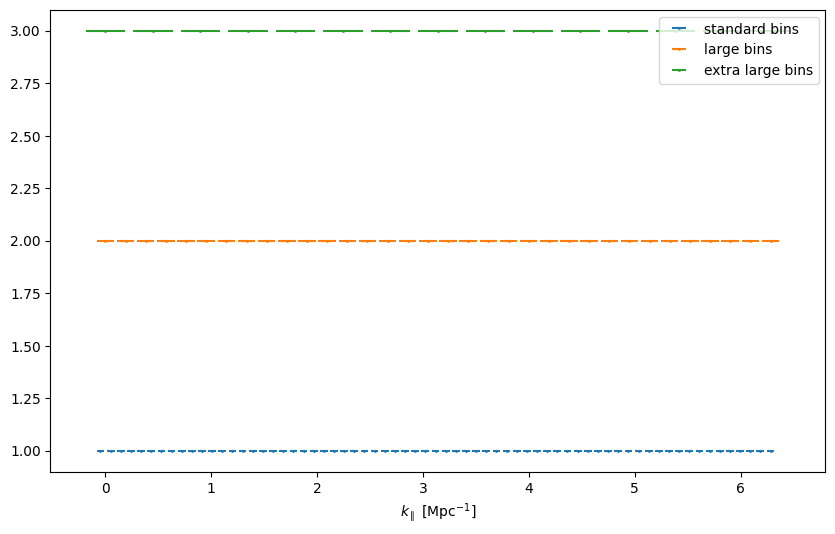

In [27]:
kpar_b = np.fft.rfftfreq(Np_b, pix_spacing_b)*2*np.pi # frequency in Mpc^-1
kmax = np.pi/pix_spacing_b
kbin_spacing = kpar_b[1]-kpar_b[0]

# make a set of bins with kpar[1:] as centers
kbin_est = np.array([[kp-(kpar_b[1]-kpar_b[0])/2, kp+(kpar_b[1]-kpar_b[0])/2] for kp in kpar_b])
Nbin = len(kbin_est)

# make a set of wider bins
Nbin_try = Nbin//2
lrgbin_edges = np.linspace(0, kmax, Nbin_try+1)
kbin_est_lrgbins = np.array([[lrgbin_edges[i], lrgbin_edges[i+1]] for i in range(Nbin_try)])
Nbin_lrg = len(kbin_est_lrgbins)

# make a set of even wider bins
Nbin_try = Nbin//4
xlbin_edges = np.linspace(0, kmax, Nbin_try)
kbin_est_xlbins = np.array([[xlbin_edges[i], xlbin_edges[i+1]] for i in range(Nbin_try-1)])
Nbin_xlrg = len(kbin_est_xlbins)

# plot each bin as center point with horizontal error bars
plt.figure(figsize=(10,6))
plt.errorbar(np.linspace(kbin_est[0][0], kbin_est[-1][1], Nbin-1), np.ones(Nbin-1), xerr=(kbin_est[0][1]-kbin_est[0][0])/2.-.01, fmt='o', label='standard bins', ms=1)
plt.errorbar(np.linspace(kbin_est_lrgbins[0][0], kbin_est_lrgbins[-1][1], Nbin_lrg), 2*np.ones(Nbin_lrg), xerr=(kbin_est_lrgbins[0][1]-kbin_est_lrgbins[0][0])/2.-.01, fmt='o', label='large bins', ms=1)
plt.errorbar(np.linspace(kbin_est_xlbins[0][0], kbin_est_xlbins[-1][1], Nbin_xlrg-1), 3*np.ones(Nbin_xlrg-1), xerr=(kbin_est_xlbins[0][1]-kbin_est_xlbins[0][0])/2.-.01, fmt='o', label='extra large bins', ms=1)
plt.xlabel(r"$k_{\parallel}$ [Mpc$^{-1}$]")
plt.legend()


Run the estimator

In [13]:
kbin_centers, theta_est, F_alpha_beta, Lalpha = est.estimate_p1d(Np_b, delta_x_matrix_binned, pix_spacing_b, delta_flux_b, kbin_est, S_fiducial_b, C0_invmat_b)

Starting P1D.
center of kbins:  [0.0, 0.09308422677303092, 0.18616845354606185, 0.2792526803190928, 0.3723369070921237, 0.4654211338651546, 0.5585053606381856, 0.6515895874112164, 0.7446738141842474, 0.8377580409572783, 0.9308422677303092, 1.0239264945033402, 1.1170107212763711, 1.2100949480494019, 1.3031791748224328, 1.3962634015954638, 1.4893476283684948, 1.5824318551415255, 1.6755160819145567, 1.7686003086875874, 1.8616845354606184, 1.9547687622336496, 2.0478529890066803, 2.140937215779711, 2.2340214425527423, 2.327105669325773, 2.4201898960988038, 2.513274122871835, 2.6063583496448657, 2.699442576417897, 2.7925268031909276, 2.8856110299639584, 2.9786952567369895, 3.0717794835100207, 3.164863710283051, 3.257947937056082, 3.3510321638291134, 3.444116390602144, 3.537200617375175, 3.6302848441482056, 3.723369070921237, 3.816453297694268, 3.9095375244672987, 4.00262175124033, 4.095705978013361, 4.188790204786391, 4.281874431559422, 4.374958658332454, 4.4680428851054845, 4.56112711187851

In [11]:
kbin_centers_lrg, theta_est_lrg, F_alpha_beta_lrg, Lalpha_lrg = est.estimate_p1d(Np_b, delta_x_matrix_binned, pix_spacing_b, delta_flux_b, kbin_est_lrgbins, S_fiducial_b, C0_invmat_b)

Starting P1D.
center of kbins:  [0.09239978392911158, 0.27719935178733474, 0.4619989196455579, 0.6467984875037811, 0.8315980553620042, 1.0163976232202274, 1.2011971910784505, 1.3859967589366737, 1.5707963267948968, 1.75559589465312, 1.940395462511343, 2.125195030369566, 2.3099945982277896, 2.4947941660860127, 2.6795937339442357, 2.864393301802459, 3.049192869660682, 3.2339924375189053, 3.4187920053771284, 3.6035915732353514, 3.788391141093575, 3.973190708951798, 4.157990276810021, 4.3427898446682445, 4.527589412526467, 4.712388980384691, 4.897188548242914, 5.081988116101137, 5.26678768395936, 5.451587251817584, 5.636386819675806, 5.821186387534029, 6.005985955392253, 6.190785523250476]
Getting derivative matrices.
Starting loop through data.
This k took 2.2170066833496094 seconds
This k took 2.2678868770599365 seconds
This k took 2.9560208320617676 seconds
This k took 2.8597607612609863 seconds
This k took 2.6522979736328125 seconds
This k took 3.1457359790802 seconds
This k took 2.790

In [12]:
kbin_centers_xlrg, theta_est_xlrg, F_alpha_beta_xlrg, Lalpha_xlrg = est.estimate_p1d(Np_b, delta_x_matrix_binned, pix_spacing_b, delta_flux_b, kbin_est_xlbins, S_fiducial_b, C0_invmat_b)

Starting P1D.
center of kbins:  [0.1963495408493621, 0.5890486225480863, 0.9817477042468106, 1.3744467859455347, 1.7671458676442588, 2.159844949342983, 2.552544031041707, 2.9452431127404317, 3.3379421944391554, 3.73064127613788, 4.123340357836604, 4.516039439535328, 4.908738521234053, 5.3014376029327765, 5.6941366846315, 6.086835766330225]
Getting derivative matrices.
Starting loop through data.
This k took 1.6039650440216064 seconds
This k took 1.5066611766815186 seconds
This k took 1.6666531562805176 seconds
This k took 1.594499111175537 seconds
This k took 1.7848351001739502 seconds
This k took 1.6177008152008057 seconds
This k took 1.5937247276306152 seconds
This k took 1.5798170566558838 seconds
This k took 2.225037097930908 seconds
This k took 1.4150779247283936 seconds
This k took 1.4958741664886475 seconds
This k took 1.6635193824768066 seconds
This k took 2.2581260204315186 seconds
This k took 1.543571949005127 seconds
This k took 1.5338571071624756 seconds
This k took 1.54792

Do the FFT measurements

In [14]:
# reshape delta_flux_k to be Ns x Np again
delta_flux_b_flat = np.ma.masked_array(np.reshape(delta_flux_b, (nskew, Np_b)))

# for those that aren't nan:
pk_all = []
for i in range(len(delta_flux_b_flat)):
    if not np.isnan(delta_flux_b_flat[i]).any():
        delta_flux_k = np.fft.rfft(delta_flux_b_flat[i])
        pk_all.append(abs(delta_flux_k)**2*pix_spacing_b/Np_b)
pk_avg = np.average(np.array(pk_all), axis=0) # average over all skewers in this axis


Bin the P1D model (initial guess) to match the binning of the $\Delta P_{1D}$ estimates

In [28]:
def bin_model(kfine, p1d_fine, kbins, nbin):
    p1d_fid_stdbins = np.zeros(nbin)
    for i,kbin in enumerate(kbins):
        kbin_indices = np.where((kfine > kbin[0]) & (kfine < kbin[1]))
        p1d_fid_stdbins[i] = np.mean(p1d_fine[kbin_indices])
    return p1d_fid_stdbins

p1d_fid_stdbins = bin_model(kfine, p1d_fine, kbin_est, Nbin)
p1d_fid_lrgbins = bin_model(kfine, p1d_fine, kbin_est_lrgbins, Nbin_lrg)
p1d_fid_xlbins = bin_model(kfine, p1d_fine, kbin_est_xlbins, Nbin_xlrg)

Plot the results

Text(0.5, 0, '$k_\\parallel$ [Mpc$^{-1}$]')

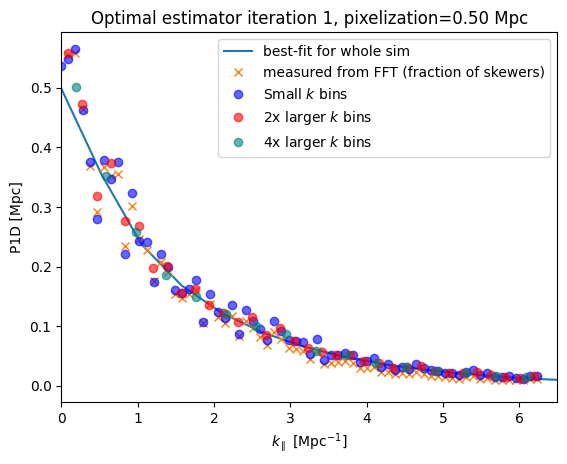

In [35]:

plt.plot(np.linspace(0, 10, 20), p1d, label='best-fit for whole sim')
plt.plot(kpar_b[1:], pk_avg[1:], marker = 'x', linestyle='none', label='measured from FFT (fraction of skewers)')

plt.plot(kbin_centers,p1d_fid_stdbins+theta_est, 'o', label=r'Small $k$ bins', color='blue', alpha=.6)
plt.plot(kbin_centers_lrg,p1d_fid_lrgbins+theta_est_lrg, 'o', label=r'2x larger $k$ bins', alpha=.6, color='red')
plt.plot(kbin_centers_xlrg,p1d_fid_xlbins+theta_est_xlrg, 'o', label=r'4x larger $k$ bins', color='teal', alpha=.6)
plt.xlim([0,6.5])
plt.legend()
plt.title("Optimal estimator iteration 1, pixelization={:.2f} Mpc".format(pix_spacing_b))
plt.ylabel("P1D [Mpc]")
plt.xlabel("$k_\parallel$ [Mpc$^{-1}$]")